## Importando bibliotecas e o dataset

### Biblioteca

In [1]:
import pandas             as pd
import matplotlib.pyplot  as plt

import spacy

from sklearn.model_selection          import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes              import MultinomialNB
from sklearn.pipeline                 import Pipeline
from collections                      import Counter
from wordcloud                        import WordCloud

In [2]:
# Carregar modelo spaCy para português
!python -m spacy download pt_core_news_sm
nlp = spacy.load('pt_core_news_sm')

  Using cached https://github.com/explosion/spacy-models/releases/download/pt_core_news_sm-3.7.0/pt_core_news_sm-3.7.0-py3-none-any.whl (13.0 MB)
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Dataset's

In [3]:
# Carregar datasets
df = pd.read_csv('/content/Base Sprint 1.csv', delimiter=';')
df_teste = pd.read_csv('/content/Base teste Sprint1.csv', delimiter=';')

## Analise preditiva do dataset

### Dataset de treino

In [4]:
df.sample(5)

,servico,comentario,sentimento
22,Emissão de carteira de trabalho,Precisei de suporte técnico para continuar.,negativo
57,Emissão de carteira de trabalho,Todo o procedimento foi muito claro.,positivo
94,Abertura de empresa,Houve muitos erros no site.,negativo
59,Abertura de empresa,Precisei de ajuda e fui prontamente atendido.,positivo
98,Licenciamento de veículo,Foi fácil e rápido licenciar meu veículo.,positivo


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   servico     100 non-null    object
 1   comentario  100 non-null    object
 2   sentimento  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [6]:
df.describe()

,servico,comentario,sentimento
count,100,100,100
unique,5,97,2
top,Emissão de RG,O site ficou fora do ar várias vezes.,positivo
freq,20,2,53


### Dataset de validação

In [7]:
df_teste.sample(5)

,servico,comentario
3,Emissão de RG,Fui muito bem atendido ao solicitar a emissão...
93,Emissão de RG,O processo de emissão do RG pelo site foi nor...
79,Licenciamento de veículo,A experiência de licenciar meu veículo pelo s...
37,Licenciamento de veículo,O processo de licenciamento pelo site foi mui...
89,Abertura de empresa,O suporte para abrir minha empresa pelo site ...


In [8]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   servico     104 non-null    object
 1   comentario  104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [9]:
df_teste.describe()

,servico,comentario
count,104,104
unique,3,77
top,Emissão de RG,Tive muitos problemas ao tentar abrir minha e...
freq,35,3


## Modelo

In [10]:
def processamento(texto):
    doc = nlp(texto.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

In [11]:
# Pré-processar os comentários
df['processado'] = df['comentario'].apply(processamento)
df_teste['processado'] = df_teste['comentario'].apply(processamento)

In [12]:
# Dividir os dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(df['processado'], df['sentimento'], test_size=0.2, random_state=42)

In [13]:
# Criar o pipeline de classificação
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Hiperparâmetros para Grid Search
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.5, 1.0]
}

In [14]:
# Grid Search com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Melhores parâmetros: {grid_search.best_params_}')
pipeline = grid_search.best_estimator_

# Avaliar no conjunto de validação
acuracia = pipeline.score(X_val, y_val)
print(f'Acuracia: {acuracia:.2f}')

Melhores parâmetros: {'clf__alpha': 0.5, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Acuracia: 0.85


In [15]:
# Classificar os comentários do dataset de teste
X_test = df_teste['processado']
predicoes = pipeline.predict(X_test)

# Adicionar as previsões ao dataframe de teste
df_teste['sentimento_predito'] = predicoes

## Visualização

In [16]:
# Análise e visualização
estatisticas = df_teste['sentimento_predito'].value_counts()
comentarios_repetidos = Counter(df_teste['comentario']).most_common()

servico_positivo = df_teste[df_teste['sentimento_predito'] == 'positivo']['servico'].mode()[0]
servico_negativo = df_teste[df_teste['sentimento_predito'] == 'negativo']['servico'].mode()[0]
servico_mais_comentado = df_teste['servico'].mode()[0]

sentimentos_por_servico = df_teste.groupby(['servico', 'sentimento_predito']).size().unstack().fillna(0)
servico_mais_positivo = sentimentos_por_servico['positivo'].idxmax()
servico_mais_negativo = sentimentos_por_servico['negativo'].idxmax()

print(f'Serviço com mais comentários: {servico_mais_comentado}')
print(f'Serviço mais positivo: {servico_mais_positivo}')
print(f'Serviço mais negativo: {servico_mais_negativo}')

Serviço com mais comentários: Emissão de RG
Serviço mais positivo: Abertura de empresa
Serviço mais negativo: Emissão de RG


In [24]:
# Contar a frequência de cada comentário para os sentimentos positivos e negativos
comentarios_positivos = df_teste[df_teste['sentimento_predito'] == 'positivo']['comentario']
comentarios_negativos = df_teste[df_teste['sentimento_predito'] == 'negativo']['comentario']

comentarios_positivos_contagem = Counter(comentarios_positivos)
comentarios_negativos_contagem = Counter(comentarios_negativos)

# Obter os 3 comentários mais frequentes para cada classe de sentimento
comentarios_positivos_relevantes = comentarios_positivos_contagem.most_common(3)
comentarios_negativos_relevantes = comentarios_negativos_contagem.most_common(3)

# Criar as tabelas de comentários mais relevantes
comentarios_positivos_df = pd.DataFrame(comentarios_positivos_relevantes, columns=['Comentário', 'Quantidade'])
comentarios_positivos_df['Sentimento'] = 'Positivo'
comentarios_positivos_df['Acurácia do Modelo'] = acuracia

comentarios_negativos_df = pd.DataFrame(comentarios_negativos_relevantes, columns=['Comentário', 'Quantidade'])
comentarios_negativos_df['Sentimento'] = 'Negativo'
comentarios_negativos_df['Acurácia do Modelo'] = acuracia

# Exibir as tabelas
print("Tabela de Comentários Mais Relevantes - Positivos:")
comentarios_positivos_df

Tabela de Comentários Mais Relevantes - Positivos:


,Comentário,Quantidade,Sentimento,Acurácia do Modelo
0,Fiquei impressionado com a facilidade de real...,3,Positivo,0.85
1,O licenciamento do meu veículo pelo site foi ...,3,Positivo,0.85
2,Tive muitos problemas ao tentar abrir minha e...,3,Positivo,0.85


In [25]:
print("\nTabela de Comentários Mais Relevantes - Negativos:")
comentarios_negativos_df


Tabela de Comentários Mais Relevantes - Negativos:


,Comentário,Quantidade,Sentimento,Acurácia do Modelo
0,Não consegui completar o processo de emissão ...,3,Negativo,0.85
1,O atendimento para emissão do RG pelo site fo...,3,Negativo,0.85
2,Não recomendo o licenciamento de veículo pelo...,3,Negativo,0.85


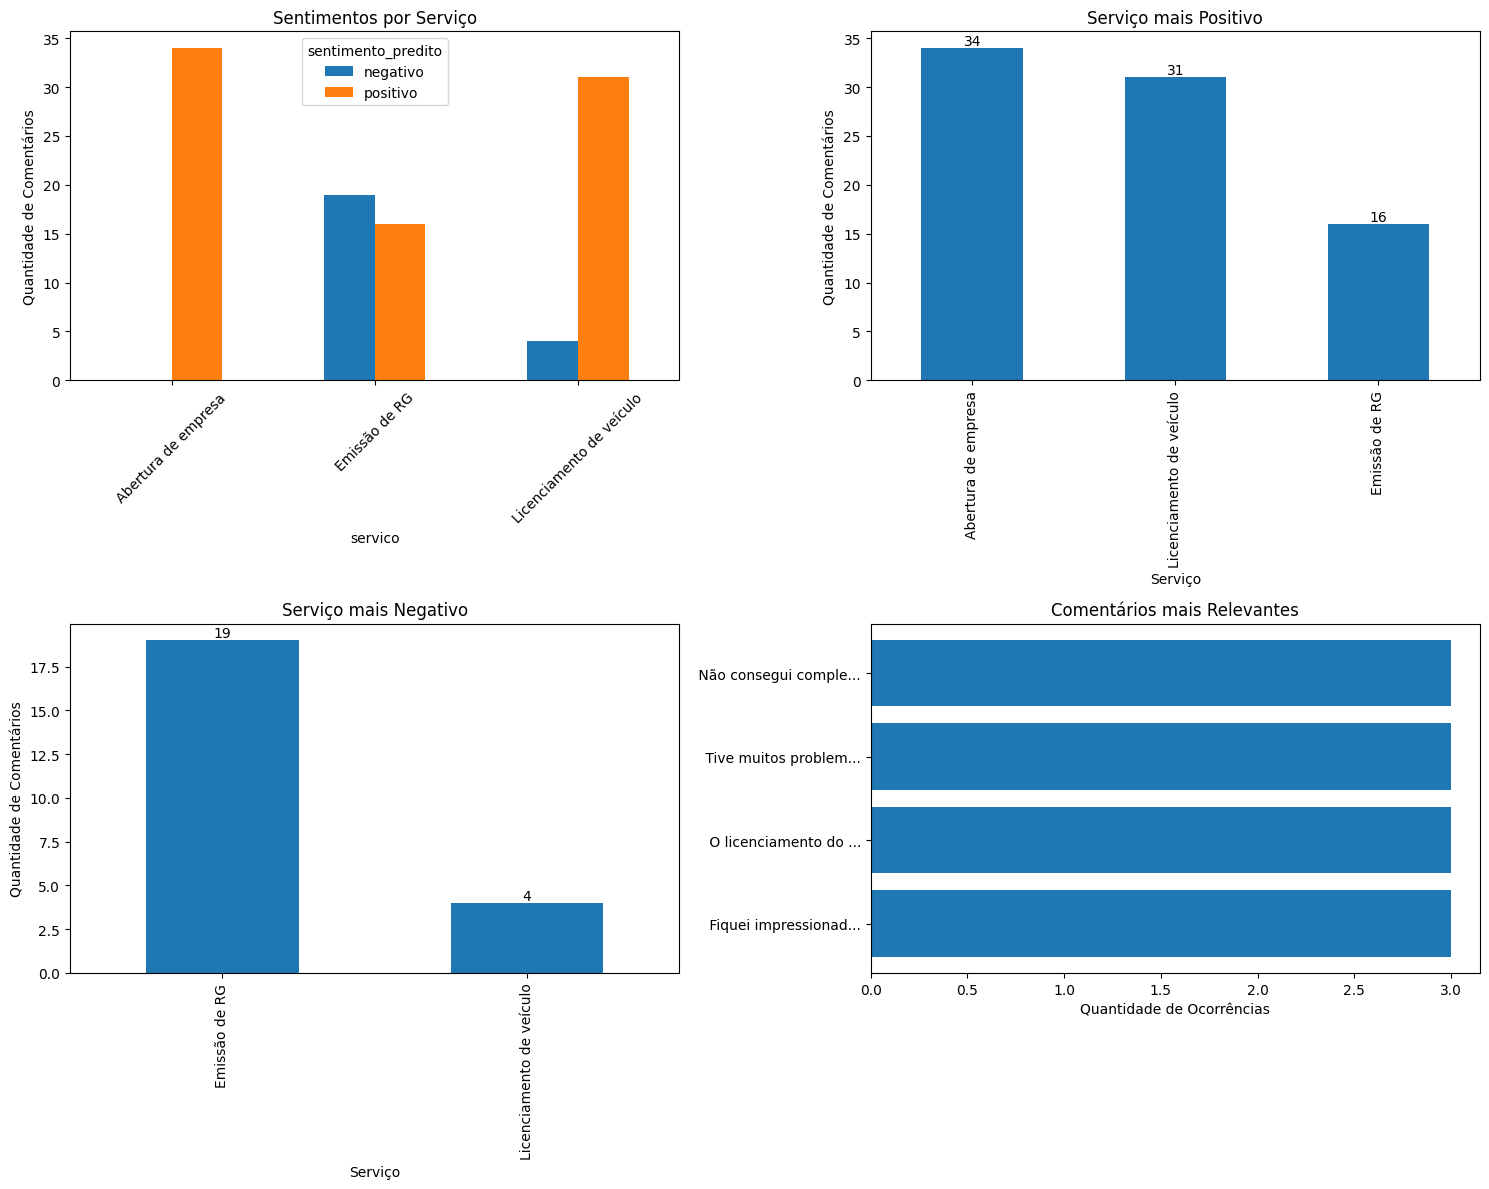

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sentimentos_por_servico.plot(kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Sentimentos por Serviço')
axes[0, 0].set_ylabel('Quantidade de Comentários')

df_teste[df_teste['sentimento_predito'] == 'positivo']['servico'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Serviço mais Positivo')
axes[0, 1].set_xlabel('Serviço')
axes[0, 1].set_ylabel('Quantidade de Comentários')

for i in axes[0, 1].patches:
    axes[0, 1].text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

df_teste[df_teste['sentimento_predito'] == 'negativo']['servico'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Serviço mais Negativo')
axes[1, 0].set_xlabel('Serviço')
axes[1, 0].set_ylabel('Quantidade de Comentários')

for i in axes[1, 0].patches:
    axes[1, 0].text(i.get_x() + i.get_width() / 2, i.get_height(), str(i.get_height()), ha='center', va='bottom')

axes[1, 1].barh([f'{comment[:20]}...' for comment, _ in comentarios_repetidos[:5]], [count for _, count in comentarios_repetidos[:5]])
axes[1, 1].set_title('Comentários mais Relevantes')
axes[1, 1].set_xlabel('Quantidade de Ocorrências')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

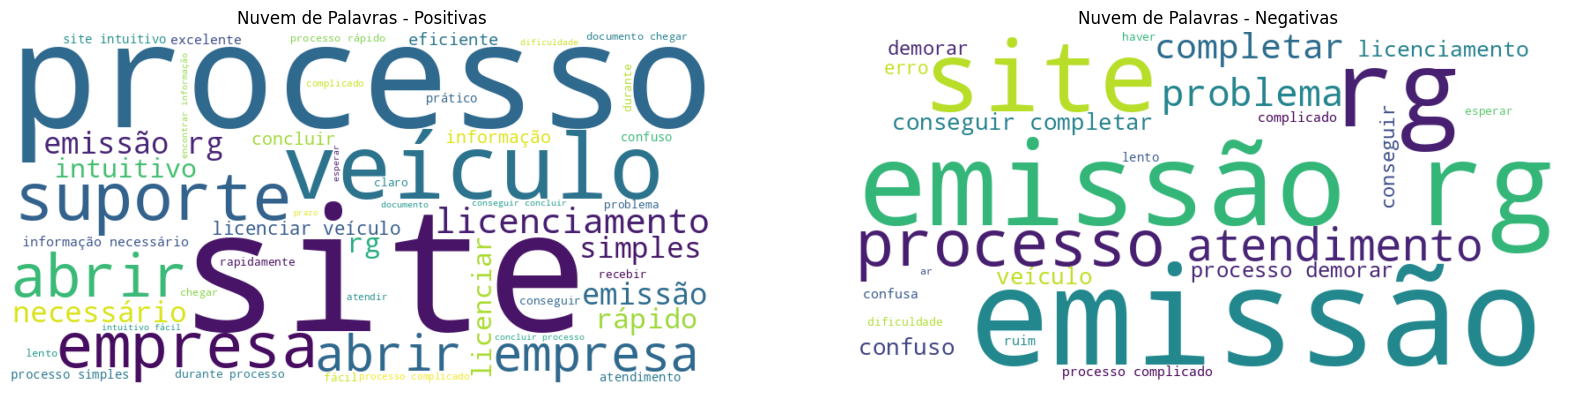

In [22]:
# Separar os comentários positivos e negativos
comentarios_positivos = df_teste[df_teste['sentimento_predito'] == 'positivo']['processado']
comentarios_negativos = df_teste[df_teste['sentimento_predito'] == 'negativo']['processado']

# Função para gerar nuvem de palavras baseada na relevância TF-IDF
def gerar_nuvem_de_palavras(comentarios):
    tfidf = TfidfVectorizer(max_df=0.75, ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(comentarios)
    sum_tfidf = tfidf_matrix.sum(axis=0)
    palavras_tfidf = [(word, sum_tfidf[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    palavras_tfidf = sorted(palavras_tfidf, key=lambda x: x[1], reverse=True)
    palavras_tfidf_dict = {word: score for word, score in palavras_tfidf}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palavras_tfidf_dict)
    return wordcloud

# Função para extrair palavras mais importantes de cada classe
def palavras_importantes_por_sentimento(pipeline, comentarios, top_n=50):
    tfidf = pipeline.named_steps['tfidf']
    clf = pipeline.named_steps['clf']

    # Transformar os comentários em uma matriz TF-IDF
    tfidf_matrix = tfidf.transform(comentarios)

    # Obter a pontuação média de TF-IDF para cada palavra
    sum_tfidf = tfidf_matrix.sum(axis=0)

    # Obter os índices das palavras com os maiores valores TF-IDF
    palavras_tfidf = [(word, sum_tfidf[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    palavras_tfidf = sorted(palavras_tfidf, key=lambda x: x[1], reverse=True)[:top_n]

    palavras_tfidf_dict = {word: score for word, score in palavras_tfidf}
    return palavras_tfidf_dict

# Gerar nuvem de palavras para os comentários positivos
palavras_positivas = palavras_importantes_por_sentimento(pipeline, comentarios_positivos)
wordcloud_positivo = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palavras_positivas)

# Gerar nuvem de palavras para os comentários negativos
palavras_negativas = palavras_importantes_por_sentimento(pipeline, comentarios_negativos)
wordcloud_negativo = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palavras_negativas)

# Plotar as nuvens de palavras
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_positivo, interpolation='bilinear')
axes[0].set_title('Nuvem de Palavras - Positivas')
axes[0].axis('off')

axes[1].imshow(wordcloud_negativo, interpolation='bilinear')
axes[1].set_title('Nuvem de Palavras - Negativas')
axes[1].axis('off')

plt.show()